In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar, minimize_scalar
from scipy.stats import linregress, gamma
from imageio import imread
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
import os
from collections import namedtuple
sns.set(style='white')

## The data

In [2]:
def load_data():
    data = {'confirmed': 'jhdata/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
            'deaths': 'jhdata/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
            'recovered': 'jhdata/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'}
    for k in data:
        data[k] = pd.read_csv(data[k])
    data = pd.concat(data, axis=0)
    data.index.names=['statistic', 'old_index']
    data = data.reset_index().drop('old_index', axis=1)
    return data

data = load_data()

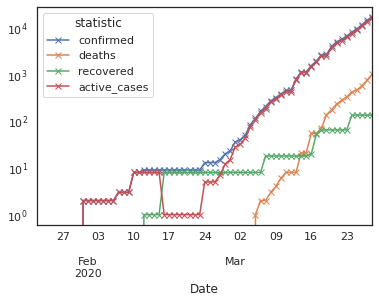

In [3]:
this_country = 'United Kingdom'
ts = data[(data['Country/Region']==this_country) & (data['Province/State'].isnull())]
ts = ts.set_index('statistic').drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1).T
ts.index.name='Date'
ts.index = pd.to_datetime(ts.index)
ts['active_cases'] = ts.confirmed - ts.deaths - ts.recovered
ts['phase'] = np.nan
ts.loc[ts.index[0], 'phase'] = 'isolated'
ts.loc['2020/03/01', 'phase'] = 'unrestricted'
ts.loc['2020/03/16', 'phase'] = 'suppressed'
ts['phase'].fillna(method='ffill', inplace=True)
ts['phase'] = pd.Categorical(ts['phase'])
ts.plot(marker='x')
plt.yscale('log')

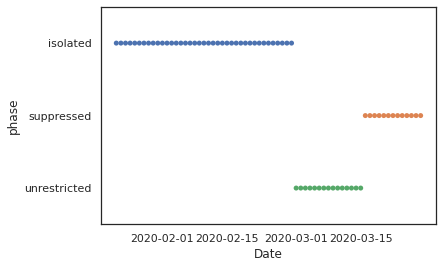

In [4]:
sns.stripplot(data=ts, x=ts.index, y='phase', jitter=0)

In [5]:
def estimate_growth(data, column):
    data = data.copy()[column]
    data = np.log(data)
    data = data[np.isfinite(data)]
    x = (data.index - data.index[0]).to_series().dt.days.values
    y = data.values
    c, _, _, _, _ = linregress(x, y)
    return np.exp(c)-1

def estimate_growth(data, column):
    data = data[data[column]>0]
    return data[column].pct_change().median()

c_growth = estimate_growth(ts[ts['phase']=='unrestricted'], 'confirmed')
d_growth = estimate_growth(ts[ts['phase']=='unrestricted'], 'deaths')
print('Cases growth rate: {:.2%}'.format(c_growth))
print('Deaths growth rate: {:.2%}'.format(d_growth))

Cases growth rate: 26.94%
Deaths growth rate: 33.33%


## Discrete Gamma Distribution

In [8]:
def dg_weights(n, mean, n_days):
    dist = gamma(n, scale=mean)
    edges = np.linspace(-0.5, n_days-0.5, n_days+1)
    p = np.diff(dist.cdf(edges))
    p /= np.sum(p)
    return p

def dp_convolve(signal, p):
    return np.convolve(signal, p, mode='full')[:len(signal)]

## The model

Define states

In [9]:
state_labels = ['S', 'E', 'I', 'R']
State = namedtuple('State', state_labels)
def make_state(S=0, E=0, I=0, R=0):
    return State(S=S, E=E, I=I, R=R)

def v2s(v):
    return State(*v)

def s2v(s):
    return np.array([*s])

And the model

In [10]:
class SEIRModel:
    def __init__(self,
                 R_0=3.,
                 T_inc=4.6,
                 T_inf=1.4):
        self.R_0 = R_0 if callable(R_0) else (lambda _: R_0)
        self.T_inc = T_inc
        self.T_inf = T_inf
        
    def __call__(self, t, y):
        y = v2s(y)
        N = y.S + y.E + y.I + y.R
        beta = self.R_0(t) / (N * self.T_inf)
        Sd = -beta * y.S * y.I
        Ed = beta * y.S * y.I - y.E / self.T_inc
        Id = y.E / self.T_inc - y.I / self.T_inf
        Rd = y.I / self.T_inf
        #Ard = self.f_ill * (1-self.f_death) * y.E / self.T_inc - y.Ar / self.T_resolve
        #Add = self.f_ill * self.f_death * y.E / self.T_inc - y.Ad / self.T_death
        #Cd = self.f_ill * y.E / self.T_inc 
        #Dd = y.Ad / self.T_death
        
        return s2v(make_state(S=Sd, E=Ed, I=Id, R=Rd))
    
    
class EmissionModel:
    def __init__(self,
                 T_ill=15.,
                 f_ill=0.06,
                 f_death = 0.15,
                 n_symptoms = 6.,
                 T_symptoms = 10.,
                 n_resolve=3,
                 T_resolve=10.,
                 n_death=8,
                 T_death=14.):
        self.p_symptoms = f_ill * dg_weights(n_symptoms, T_symptoms/n_symptoms, int(T_symptoms*30))
        self.p_resolve = (1-f_death) * dg_weights(n_resolve, T_resolve/n_resolve, int(T_resolve*30))
        self.p_death = f_death * dg_weights(n_death, T_death/n_death, int(T_death*30))
        
    def add_observables(self, sim):
        sim['All exposed'] = sim.E + sim.I + sim.R
        sim['Daily exposed'] = sim['All exposed'].diff()
        sim['Daily exposed'].iloc[0] = 0.
        sim['Daily admissions'] = dp_convolve(sim['Daily exposed'],
                                            self.p_symptoms)
        sim['Daily remissions'] = dp_convolve(sim['Daily admissions'],
                                              self.p_resolve)
        sim['Daily deaths'] = dp_convolve(sim['Daily admissions'],
                                          self.p_death)
        sim['All admissions'] = sim['Daily admissions'].cumsum()
        sim['All remissions'] = sim['Daily remissions'].cumsum()
        sim['All deaths'] = sim['Daily deaths'].cumsum()
        sim['Active cases'] = (sim['All admissions'] -
                               sim['All remissions'] -
                               sim['All deaths'])
        return sim
        

def pos_eigenvalue(R_0, T_inc, T_inf, S_over_N=1.):
    return (0.5 * (1/T_inc + 1/T_inf) *
            (-1 + np.sqrt(1 + 4 * (R_0 * S_over_N - 1) *
                          T_inc * T_inf / ((T_inf+T_inc)**2))))
    
def calibrate_transmission_model(early_growth_rate,
                                 mean_generation_time,
                                 lat_fraction):
    T_inc = lat_fraction * mean_generation_time
    T_inf = mean_generation_time - T_inc
    def root_equation(R_0):
        return np.exp(pos_eigenvalue(R_0, T_inc, T_inf)) - 1. - early_growth_rate
    rf = root_scalar(root_equation, bracket=[0.1, 100.])
    if not rf.converged:
        print(rf.flag)
    return {'R_0':rf.root, 'T_inc': T_inc, 'T_inf': T_inf}
    
def run_outbreak(transmission_model,
                 emission_model,
                 sim_time_days, initial_state):
    sim_time_days = int(sim_time_days)
    t_eval = np.linspace(0, sim_time_days, sim_time_days+1)
    ivp = solve_ivp(transmission_model, (0, sim_time_days), s2v(initial_state), t_eval=t_eval)
    if ivp.status != 0:
        print(ivp.message)
    result = pd.DataFrame(ivp.y.T,
                          index=ivp.t,
                          columns=state_labels)
    result = emission_model.add_observables(result)
    return result

def calibrate_timing_to_cases(sim, ts):
    ref_date = ts.index[0]
    ts = ts.copy()
    ts.index = (ts.index - ts.index[0]).to_series().dt.days
    def mape(shift):
        C = np.interp(ts.index+shift, sim.index, sim['All admissions'].values)
        return (C / ts.confirmed - 1).abs().mean()
    opt = minimize_scalar(mape)
    if not opt.success:
        print(opt)
        raise RuntimeError('Optimiser failed')
    opt_shift = round(opt.x)
    result = sim.copy()
    result.index = ref_date + pd.to_timedelta(sim.index - opt_shift, unit='D')
    return result

def identify_date(sim, ts, target_date='2020/03/14'):
    target_date = pd.to_datetime(target_date)
    target_value = ts.confirmed[target_date]
    try:
        date_offset = sim.index[sim['All admissions']>target_value][0]
    except IndexError: 
        raise ValueError("Cannot find suitable date offset")
    result = sim.copy()
    result.index = target_date + pd.to_timedelta(sim.index - date_offset, unit='D')
    return result

How does R_0 vary as you change the fraction of the mean generation time that is latent?

0.100000    2.967113
0.142105    3.059920
0.184211    3.142415
0.226316    3.214599
0.268421    3.276470
0.310526    3.328029
0.352632    3.369277
0.394737    3.400213
0.436842    3.420837
0.478947    3.431148
0.521053    3.431148
0.563158    3.420837
0.605263    3.400213
0.647368    3.369277
0.689474    3.328029
0.731579    3.276470
0.773684    3.214599
0.815789    3.142415
0.857895    3.059920
0.900000    2.967113
Name: R_0, dtype: float64

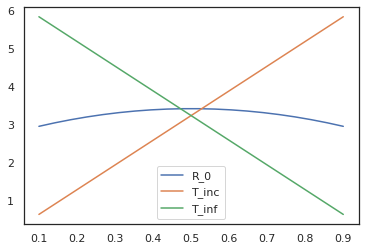

In [11]:
def plot_R_0_dependence(early_growth_rate, mean_generation_time):
    xs = np.linspace(0.1, 0.9, 20)
    ys = {lf: pd.Series(calibrate_transmission_model(early_growth_rate,
                                                 mean_generation_time,
                                                 lf),
                    name=lf) for lf in xs}
    df = pd.DataFrame(ys).T
    df.plot()
    display(df['R_0'])
    
plot_R_0_dependence(0.3, 6.5)

In [12]:
calibrate_transmission_model(0.3, 6.5, 0.71)

{'R_0': 3.304182376903656, 'T_inc': 4.615, 'T_inf': 1.8849999999999998}

In [22]:
def plot_simulation(sim, transmission_model):
    n_plots = 2
    f, axs = plt.subplots(n_plots, 1, figsize=(12, 6*n_plots), squeeze=False)
    axs = axs.ravel()
    sim[['All admissions', 'Active cases', 'All deaths', 'Daily deaths', 'I']].plot(ax=axs[0])
    #sim[['N', 'S', 'E', 'I', 'R']].plot(ax=axs[0])
    ts[['confirmed', 'deaths']][ts['phase']=='unrestricted'].plot(marker='x', linestyle=':',ax=axs[0])
    axs[0].set_yscale('log')
    axs[0].set_ylim(1, None)
    #axs[0].set_ylim(.001, 1.05 * y_height)
    (np.exp(sim.E / sim.I / transmission_model.T_inc - 1./transmission_model.T_inf)-1).rename('I growth').plot(ax=axs[1])
    #(sim.I.diff() / (0.5*(sim.I.shift(1) + sim.I.shift(1)))).rename('debug').plot(ax=axs[1])
    axs[1].set_ylim(-0.2, 0.4)
    axs[1].axhline(0.3, color='r', linestyle=':')
    for ax in axs:
        ax.legend()
        ax.set_xlabel('Date')
        #ax.xaxis.set_major_locator(ticker.AutoLocator())

Original Ferguson Model

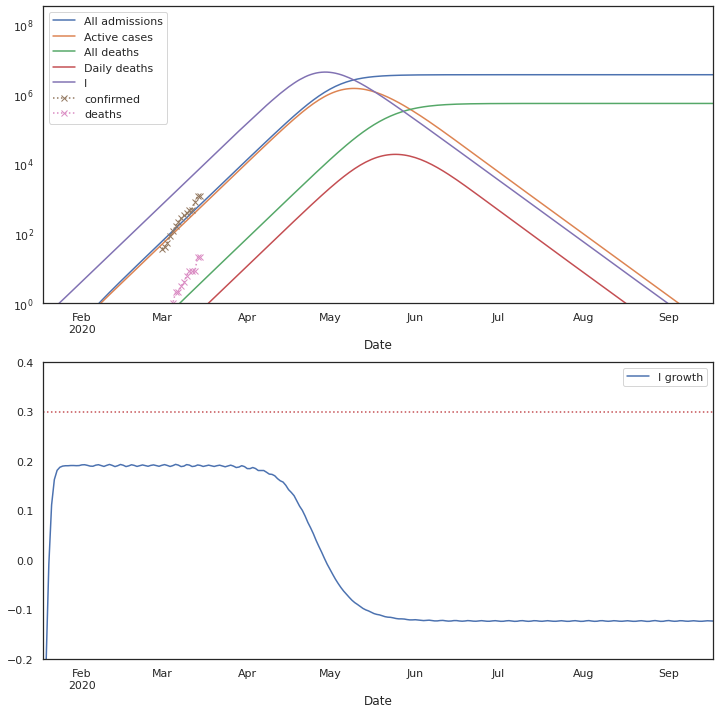

In [23]:
transmission_parameters = calibrate_transmission_model(0.3, 6.5, 0.71)
t_model = SEIRModel(**transmission_parameters)
e_model = EmissionModel(f_ill=0.06, f_death=0.15,
                        n_symptoms=9, T_symptoms=10,
                        n_resolve=9, T_resolve=10,
                        n_death=16, T_death=21)
t_model.R_0 = lambda _: 2.4
sim_orig = run_outbreak(t_model, e_model, 2*365//3, make_state(S=6.64e7, I=1))
sim_orig = calibrate_timing_to_cases(sim_orig,
                         ts[ts['phase']=='unrestricted'])
plot_simulation(sim_orig, t_model)

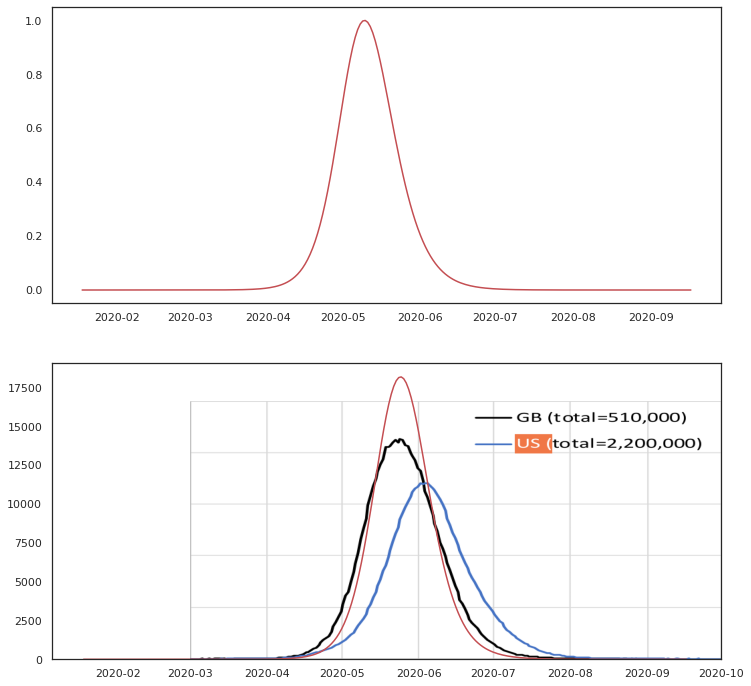

In [24]:
f, (ax_a, ax_d) = plt.subplots(2, 1, figsize=(12, 12))
#ax_a.imshow(imread('ferguson-plots/active-cases.png'),
#            extent=(mdates.datestr2num('2020/03/01'),
#                    mdates.datestr2num('2020/10/01'), 0., 1.), aspect=100)
ax_a.xaxis_date()
ax_a.plot(sim_orig.index.to_series().apply(mdates.date2num).values,
          (sim_orig['Active cases']/sim_orig['Active cases'].max()).values,
          'r')
ax_d.imshow(imread('ferguson-plots/deaths.png'),
            extent=(mdates.datestr2num('2020/03/01'),
                    mdates.datestr2num('2020/10/01'), 0., 66400000*25/100000), aspect='auto')
ax_d.xaxis_date()
ax_d.plot(sim_orig.index.to_series().apply(mdates.date2num).values,
          sim_orig['Daily deaths'].values,
          'r')
#(sim_orig['Active cases']/sim_orig['Active cases'].max()).plot(ax=ax_a)
#ax_a.set_xlim('2020/03/01',
#              '2020/10/01')
#ax_a.set_ylim(0., 1.)

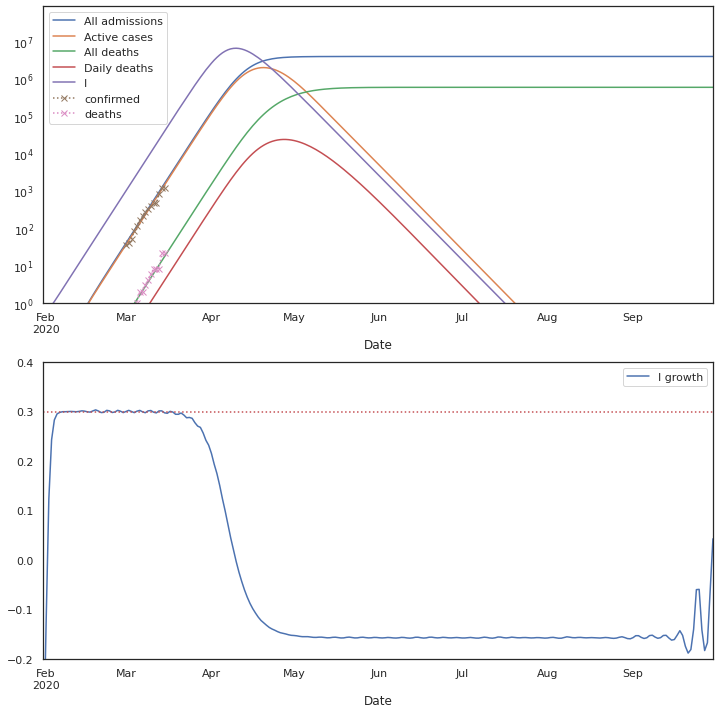

In [25]:
transmission_parameters = calibrate_transmission_model(0.3, 6.5, 0.71)
t_model = SEIRModel(**transmission_parameters)
e_model = EmissionModel(f_ill=0.06, f_death=0.15,
                        n_symptoms=9, T_symptoms=10,
                        n_resolve=9, T_resolve=10,
                        n_death=4, T_death=14)
sim_correct_R_0 = run_outbreak(t_model, e_model, 2*365//3, make_state(S=6.64e7, I=1))
sim_correct_R_0 = calibrate_timing_to_cases(sim_correct_R_0,
                         ts[ts['phase']=='unrestricted'])
plot_simulation(sim_correct_R_0, t_model)

(18322.0, 18474.0)

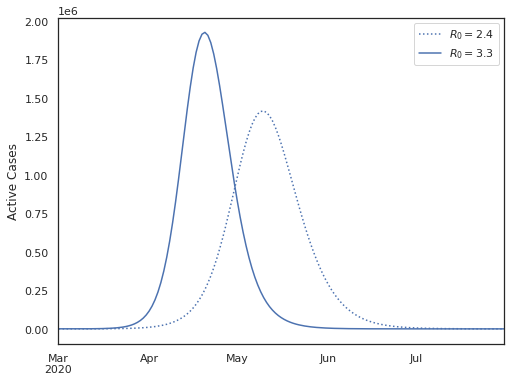

In [26]:
plt.figure(figsize=(8,6))
sim_orig['Active cases'].rename('$R_0 = 2.4$').plot(ax=plt.gca(), color='b', ls=':')
sim_correct_R_0['Active cases'].rename('$R_0 = 3.3$').plot(ax=plt.gca(), color='b')
plt.legend()
plt.ylabel('Active Cases')
plt.xlim('2020/03/01', '2020/07/31')

(18322.0, 18474.0)

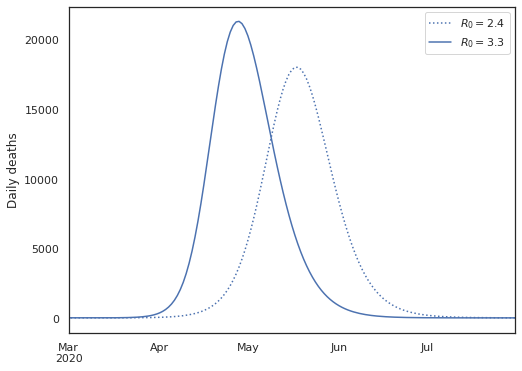

In [72]:
plt.figure(figsize=(8,6))
sim_orig['Daily deaths'].rename('$R_0 = 2.4$').plot(ax=plt.gca(), color='b', ls=':')
sim_correct_R_0['Daily deaths'].rename('$R_0 = 3.3$').plot(ax=plt.gca(), color='b')
plt.legend()
plt.ylabel('Daily deaths')
plt.xlim('2020/03/01', '2020/07/31')

In [73]:
1. - sim_orig['S'].iloc[-1] / sim_orig['S'].iloc[0]

0.8785978807824611

In [58]:
sim_orig['All deaths'].iloc[-1]

525050.0393706011

In [534]:
0.51 / (66.4*0.81)

0.009482373940205265

In [150]:
sim.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
               '2020-06-26', '2020-06-27', '2020-06-28', '2020-06-29',
               '2020-06-30', '2020-07-01'],
              dtype='datetime64[ns]', length=183, freq=None)

In [127]:
pd.to_datetime('2020/01/01', format="%Y/%m/%d")

Timestamp('2020-01-01 00:00:00')

In [130]:
pd.to_timedelta(sim.index, unit="D") + pd.to_datetime('2020/01/01', format="%Y/%m/%d")

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
               '2020-06-26', '2020-06-27', '2020-06-28', '2020-06-29',
               '2020-06-30', '2020-07-01'],
              dtype='datetime64[ns]', length=183, freq=None)